# Data exploration

Dit notebook zal worden gebruikt voor het vinden van interessante features.

In [101]:
# imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import TargetEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
# Kolommen die niet met n.v.t. of "?" werden aangegeven in de data dictionary.
# Zulke kolommen mochten wij negeren (volgens het interview)
cols_to_use= [
 '#stm_sap_meldnr',
 'stm_mon_nr',
 'stm_vl_post',
 'stm_sap_meld_ddt',
 'stm_sap_meldtekst_lang',
 'stm_sap_meldtekst',
 'stm_geo_mld',
 'stm_equipm_nr_mld',
 'stm_equipm_soort_mld',
 'stm_equipm_omschr_mld',
 'stm_km_van_mld',
 'stm_km_tot_mld',
 'stm_prioriteit',
 'stm_aanngeb_ddt',
 'stm_oh_pg_gst',
 'stm_geo_gst',
 'stm_equipm_nr_gst',
 'stm_equipm_soort_gst',
 'stm_equipm_omschr_gst',
 'stm_km_van_gst',
 'stm_km_tot_gst',
 'stm_oorz_groep',
 'stm_oorz_code',
 'stm_oorz_tkst',
 'stm_fh_ddt',
 'stm_fh_status',
 'stm_sap_storeind_ddt',
 'stm_tao_indicator',
 'stm_tao_indicator_vorige',
 'stm_tao_soort_mutatie',
 'stm_tao_telling_mutatie',
 'stm_tao_beinvloedbaar_indicator',
 'stm_sap_melddatum',
 'stm_sap_meldtijd',
 'stm_contractgeb_mld',
 'stm_techn_mld',
 'stm_contractgeb_gst',
 'stm_techn_gst',
 'stm_aanngeb_dd',
 'stm_aanngeb_tijd',
 'stm_aanntpl_dd',
 'stm_aanntpl_tijd',
 'stm_progfh_in_datum',
 'stm_progfh_in_tijd',
 'stm_progfh_in_invoer_dat',
 'stm_progfh_in_invoer_tijd',
 'stm_progfh_in_duur',
 'stm_progfh_gw_tijd',
 'stm_progfh_gw_lwd_datum',
 'stm_progfh_gw_lwd_tijd',
 'stm_progfh_gw_duur',
 'stm_progfh_gw_teller',
 'stm_fh_dd',
 'stm_fh_tijd',
 'stm_fh_duur',
 'stm_sap_storeinddatum',
 'stm_sap_storeindtijd',
 'stm_oorz_tekst_kort',
 'stm_pplg_van',
 'stm_pplg_naar',
 'stm_dstrglp_van',
 'stm_dstrglp_naar']

In [73]:
df = pd.read_csv("data/sap_storing_data_hu_project.csv", index_col=0, usecols=cols_to_use, engine='pyarrow')

## Target variabele aanmaken

Target variabele anm_tot_fh, welke de duur vanaf dat de aannemer ter plaatse is, tot het daadwerkelijke functieherstel.

In [74]:
# Convert columns to datetime type
df['stm_aanntpl_tijd'] = pd.to_datetime(df['stm_aanntpl_tijd'], format='%H:%M:%S', errors='coerce')
df['stm_aanntpl_dd'] = pd.to_datetime(df['stm_aanntpl_dd'], format='%d/%m/%Y', errors='coerce')
df['stm_fh_ddt'] = pd.to_datetime(df['stm_fh_ddt'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Combine date and time columns to a datetime column
df['stm_aanntpl_tijd'] = df['stm_aanntpl_tijd'].astype('str')
df['stm_aanntpl_dd'] = df['stm_aanntpl_dd'].astype('str')
df["aanntpl_ddt"] = df["stm_aanntpl_dd"] + " " + df["stm_aanntpl_tijd"].apply(lambda x: x.split(' ')[-1])
df['aanntpl_ddt'] = pd.to_datetime(df['aanntpl_ddt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df = df.dropna(subset=['aanntpl_ddt'])

In [75]:
# Maak een kolom met de duur van de aannemer ter plaatse tot functieherstel
df['anm_tot_fh'] = df['stm_fh_ddt'] - df['aanntpl_ddt']
df['anm_tot_fh'] = df['anm_tot_fh'].apply(lambda x: x.seconds/60 + x.days * (24*60))
df = df.dropna(subset=['anm_tot_fh'])

We halen negatieve waardes voor de targetvariabele uit de dataset. \
Deze zijn voor ons model, wat de functiehersteltijd wilt berekenen als de aannemer
ter plaatse is gekomen niet relevant. Het probleem is dan namelijk al opgelost. \
\
Verder is ons verteld dat wij storingen met een verwachte functieherstelduur van korter
dan 5 minuten of langer dan 8 uur mogen weglaten. \ 
Deze storingen zijn óf zodanig snel opgelost dat deze niet nuttig zijn om een voorspelling voor te doen, \
óf zodanig lang, dat het treinverkeer toch niet snel zal rijden, en het beter is om af te wachten.

In [76]:
# We halen negatieve waardes voor de targetvariabele uit de data
df = df[df['anm_tot_fh'] >= 0]
# We halen prognoses voor korter dan 5 minuten en langer dan 8 uur uit de data
df = df[(df['anm_tot_fh'] >= 5) & (df['anm_tot_fh'] <= 480)]

In [77]:
def remove_outlier(df_in, col_name, k=3):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 
    fence_low  = q1 - k * iqr
    fence_high = q3 + k * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

## Data exploration

### stm_progfh_in_duur

In [95]:
# Remove nonsense values
dfprog = df
dfprog['stm_progfh_in_duur'] = df['stm_progfh_in_duur'].str.extract('(\d+)', expand=False)
dfprog['stm_progfh_in_duur'] = dfprog['stm_progfh_in_duur'].astype('int32')
dfprog = dfprog[dfprog.stm_progfh_in_duur != 99999999]
dfprog = dfprog[dfprog.stm_progfh_in_duur != 0]

In [96]:
dfprog = remove_outlier(dfprog, 'stm_progfh_in_duur')

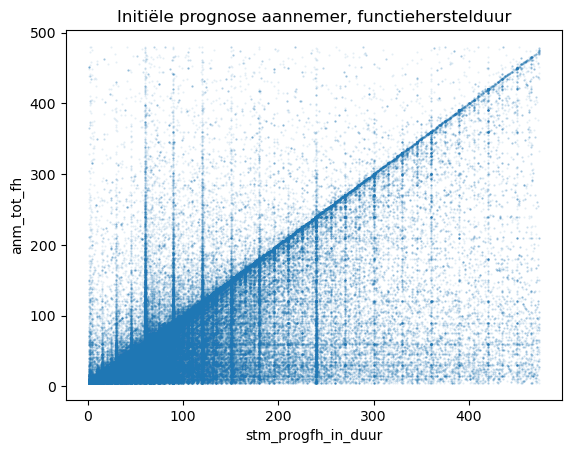

In [97]:
plt.scatter(dfprog['stm_progfh_in_duur'], dfprog['anm_tot_fh'], s=0.3, alpha=0.1)
plt.title('Initiële prognose aannemer, functieherstelduur')
plt.xlabel('stm_progfh_in_duur')
plt.ylabel('anm_tot_fh')
# plt.plot(np.arange(0,500), np.repeat(60, 500))
# plt.plot(np.arange(0, 500), np.arange(0, 500), color='red')
plt.show()

In [39]:
df.corr(numeric_only=True)['anm_tot_fh']

stm_mon_nr                 0.058842
stm_equipm_nr_mld          0.004377
stm_km_van_mld             0.000845
stm_km_tot_mld             0.023466
stm_prioriteit             0.065555
stm_equipm_nr_gst          0.011635
stm_km_van_gst             0.001569
stm_km_tot_gst             0.013892
stm_oorz_code              0.001064
stm_fh_status             -0.043950
stm_tao_telling_mutatie    0.026903
stm_contractgeb_mld       -0.031650
stm_contractgeb_gst       -0.031088
stm_progfh_in_duur        -0.042793
stm_progfh_gw_lwd_datum    0.040563
stm_progfh_gw_teller       0.101333
stm_fh_duur                0.076504
anm_tot_fh                 1.000000
Name: anm_tot_fh, dtype: float64

In [40]:
# pd.options.display.max_rows = 1000
with pd.option_context("display.max_rows", 100):
    print(df['stm_oorz_code'].value_counts())

221.0    90363
218.0    65302
215.0    63459
135.0    27052
151.0    26301
133.0    24859
145.0    24229
294.0    23601
143.0    17046
213.0    14072
225.0    11032
140.0    10665
147.0    10154
203.0     8473
212.0     8037
298.0     7580
207.0     5859
219.0     5754
230.0     5348
146.0     5310
184.0     4749
241.0     4682
181.0     4542
183.0     4304
150.0     4284
226.0     4134
227.0     4033
182.0     3625
149.0     3536
209.0     3293
186.0     3107
228.0     2906
154.0     2796
214.0     2599
220.0     2195
187.0     2184
223.0     2133
222.0     2122
210.0     1970
144.0     1727
148.0     1646
299.0     1545
132.0     1507
211.0     1464
229.0     1431
240.0     1401
201.0     1091
242.0      911
204.0      703
208.0      701
250.0      669
185.0      540
234.0      514
224.0      485
188.0      468
141.0      423
142.0      311
235.0      235
231.0      197
134.0      146
239.0      130
189.0      128
206.0      105
131.0       97
130.0       66
202.0       52
136.0     

### stm_oorz_groep

In [41]:
df['stm_oorz_groep'].unique()

array(['TECHONV', '', 'ONR-RIB', 'ONR-DERD', 'WEER'], dtype=object)

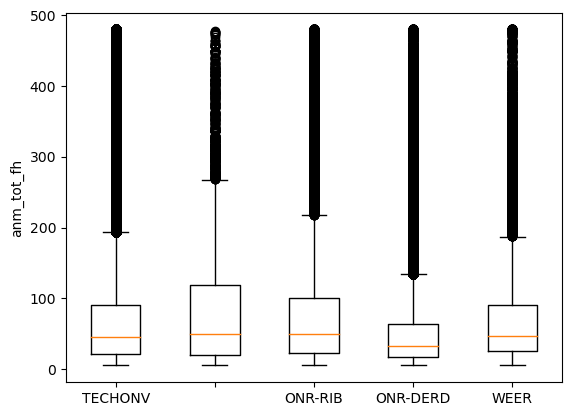

In [42]:
boxplot_data = [df[df.stm_oorz_groep == value]['anm_tot_fh'] for value in df['stm_oorz_groep'].unique()]

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xticklabels(df['stm_oorz_groep'].unique())
ax.set_ylabel('anm_tot_fh')
plt.show()

In [43]:
for value in ['ONR-RIB', 'ONR-DERD', 'TECHONV', 'WEER']:
    print(df[df.stm_oorz_groep == value]['anm_tot_fh'].quantile([0.25, 0.5, 0.75]))

0.25     23.0
0.50     49.0
0.75    101.0
Name: anm_tot_fh, dtype: float64
0.25    17.0
0.50    33.0
0.75    64.0
Name: anm_tot_fh, dtype: float64
0.25    21.0
0.50    45.0
0.75    90.0
Name: anm_tot_fh, dtype: float64
0.25    25.0
0.50    46.0
0.75    90.0
Name: anm_tot_fh, dtype: float64


### stm_geo_mld

Text(0, 0.5, 'Mediaan anm_tot_fh per geocode')

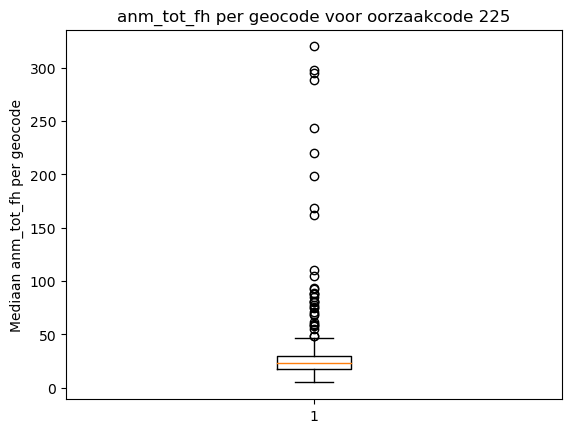

In [44]:
median_time = []
for value in df['stm_geo_mld'].unique():
    median_time.append(df[(df.stm_geo_mld == value) & (df.stm_oorz_code == 225)]['anm_tot_fh'].median())

median_time = [x for x in median_time if str(x) != 'nan']

plt.boxplot(median_time)
plt.title('anm_tot_fh per geocode voor oorzaakcode 225')
plt.ylabel('Mediaan anm_tot_fh per geocode')

### stm_contractgeb_mld

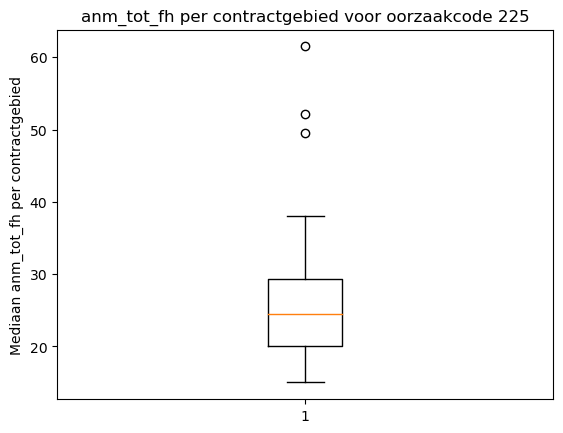

In [45]:
contract_time = []
for cont in df['stm_contractgeb_mld'].unique():
    contract_time.append(df[(df.stm_contractgeb_mld == cont) & (df.stm_oorz_code == 225)]['anm_tot_fh'].median())

contract_time = [x for x in contract_time if str(x) != 'nan']

plt.boxplot(contract_time)
plt.title('anm_tot_fh per contractgebied voor oorzaakcode 225')
plt.ylabel('Mediaan anm_tot_fh per contractgebied')
plt.show()
print('')

### stm_prioriteit

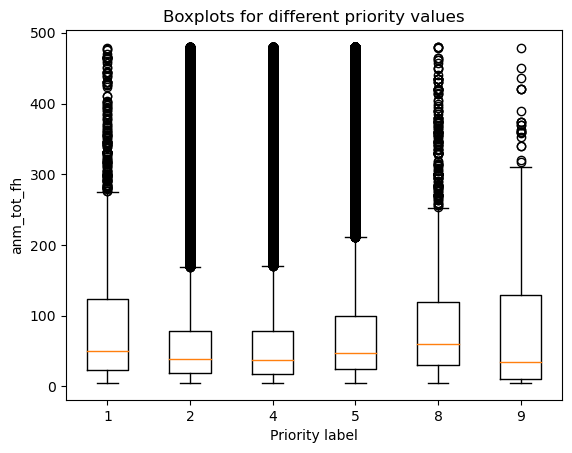

In [46]:
boxplot_data = [df[df.stm_prioriteit == value]['anm_tot_fh'] for value in [1,2,4,5,8,9]]

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xticklabels([1,2,4,5,8,9])
ax.set_xlabel('Priority label')
ax.set_ylabel('anm_tot_fh')
plt.title('Boxplots for different priority values')
plt.show()

### stm_techn_mld

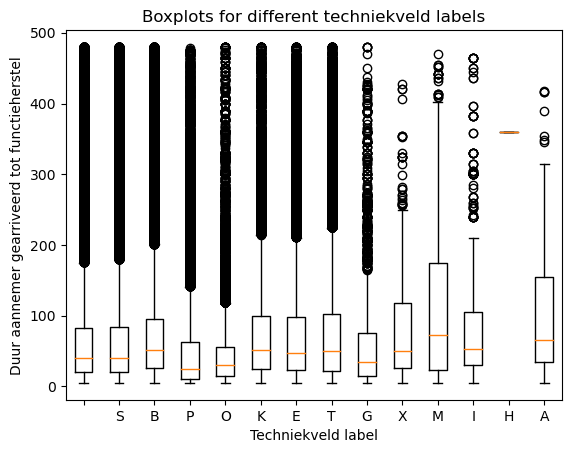

In [70]:
boxplot_data = [df[df.stm_techn_mld == value]['anm_tot_fh'] for value in df['stm_techn_mld'].unique()]

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xticklabels(df['stm_techn_mld'].unique())
ax.set_xlabel('Techniekveld label')
ax.set_ylabel('Duur aannemer gearriveerd tot functieherstel')
plt.title('Boxplots for different techniekveld labels')
plt.show()

### stm_oorzaak_code

In [48]:
len(df['stm_oorz_code'].unique())

75

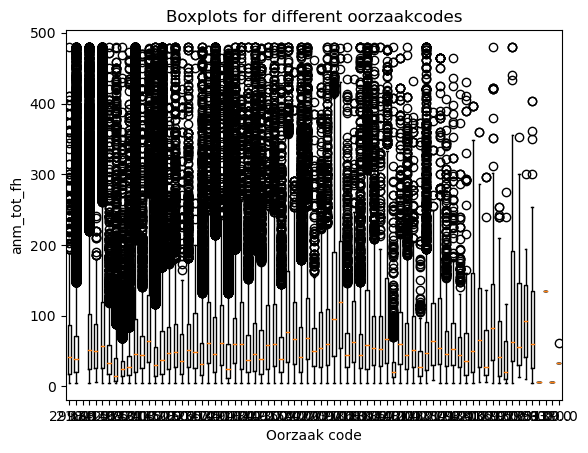

In [49]:
boxplot_data = [df[df.stm_oorz_code == value]['anm_tot_fh'] for value in df['stm_oorz_code'].unique()]

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xticklabels(df['stm_oorz_code'].unique())
ax.set_xlabel('Oorzaak code')
ax.set_ylabel('anm_tot_fh')
plt.title('Boxplots for different oorzaakcodes')
plt.show()

## DataPrep klad

### geo_score column

In [50]:
# For how many different geocodes we perform this operation
len(df['stm_geo_mld'].unique()), len(median_time)

(757, 387)

In [51]:
# geocode to score dictionary
geo_dict = {}
for geocode in df['stm_geo_mld'].unique():
    geo_dict[geocode] = (df[(df.stm_geo_mld == geocode) & (df.stm_oorz_code == 225)]['anm_tot_fh'].median())/max(median_time)

In [52]:
df['geo_score'] = df['stm_geo_mld'].apply(lambda x: geo_dict[x])

### contractgeb_score

In [53]:
len(df['stm_contractgeb_mld'].unique()), len(contract_time)

(58, 40)

In [54]:
# contractgebied to score dictionary
contrgb_dict = {}
for contr_geb in df['stm_contractgeb_mld'].unique():
    contrgb_dict[contr_geb] = (df[(df.stm_contractgeb_mld == contr_geb) & (df.stm_oorz_code == 225)]['anm_tot_fh'].median())/max(contract_time)

In [55]:
df['contractgeb_score'] = df['stm_contractgeb_mld'].apply(lambda x: contrgb_dict[x] if str(x) != 'nan' else np.nan)

In [56]:
df[['stm_contractgeb_mld', 'contractgeb_score']].sample(20)

,stm_contractgeb_mld,contractgeb_score
#stm_sap_meldnr,,
80806026,34.0,0.325203
80866336,25.0,0.357724
70321032,2.0,0.422764
80750490,30.0,0.471545
80829124,22.0,0.308943
80560415,12.0,0.317073
80381972,5.0,0.439024
80362984,26.0,0.341463
80755854,37.0,0.341463


In [57]:
df['stm_contractgeb_mld'].isna().sum()

85013

### stm_oorz_groep

In [58]:
df['stm_oorz_groep'].isna().sum()

0

In [59]:
orz_dict = {'TECHONV':0, '':0, 'ONR-RIB':0, 'ONR-DERD':1, 'WEER':0}
df['oorz_groep_cluster'] = df['stm_oorz_groep'].apply(lambda x: orz_dict[x])

### stm_prioriteit

Willen we dit doen?

### stm_techn_mld

In [60]:
techncl_dict = {'':1, 'S':1,'B':1,'K':1,'E':1,'T':1,'X':1,'I':1, 
                'P':0,'O':0,'G':0,
                'M':2,'A':2, 
                'H':3}
df['techn_cluster'] = df['stm_techn_mld'].apply(lambda x: techncl_dict[x])
# 4 aparte kolommen

### stm_oorz_code

In [61]:
grouped = df[['stm_oorz_code', 'anm_tot_fh']].groupby(['stm_oorz_code']).median()
grouped

,anm_tot_fh
stm_oorz_code,
33.0,135.000000
51.0,7.000000
130.0,62.983333
131.0,64.000000
132.0,60.000000
...,...
250.0,36.533333
294.0,25.000000
298.0,15.000000


In [62]:
grouped.sort_values(by=['anm_tot_fh'])

,anm_tot_fh
stm_oorz_code,
51.0,7.000000
139.0,7.000000
298.0,15.000000
148.0,20.316667
205.0,20.500000
...,...
189.0,82.000000
233.0,92.000000
227.0,95.000000


In [63]:
oorzcd_dict = {}
for oorzc in df['stm_oorz_code'].unique():
    oorzcd_dict[oorzc] = (df[df.stm_oorz_code == oorzc]['anm_tot_fh'].median())
oorzcd_dict

{299.0: 42.0,
 218.0: 39.0,
 nan: nan,
 133.0: 51.0,
 142.0: 50.0,
 215.0: 57.0,
 146.0: 33.0,
 298.0: 15.0,
 225.0: 24.0,
 143.0: 27.0,
 221.0: 46.0,
 241.0: 44.33333333333333,
 203.0: 64.0,
 145.0: 30.0,
 151.0: 37.0,
 228.0: 47.99166666666667,
 219.0: 49.0,
 250.0: 36.53333333333333,
 226.0: 51.916666666666664,
 235.0: 48.083333333333336,
 147.0: 32.0,
 214.0: 61.05,
 135.0: 46.0,
 240.0: 61.0,
 294.0: 25.0,
 213.0: 60.0,
 132.0: 60.0,
 184.0: 38.0,
 140.0: 46.0,
 149.0: 39.0,
 222.0: 59.11666666666667,
 230.0: 59.983333333333334,
 150.0: 39.0,
 154.0: 77.01666666666667,
 224.0: 67.0,
 212.0: 42.0,
 207.0: 69.0,
 201.0: 50.0,
 223.0: 54.0,
 209.0: 60.0,
 227.0: 95.0,
 210.0: 120.0,
 186.0: 45.0,
 208.0: 63.0,
 183.0: 44.0,
 181.0: 59.0,
 187.0: 54.0,
 185.0: 53.5,
 144.0: 67.63333333333334,
 148.0: 20.316666666666666,
 211.0: 60.0,
 220.0: 45.0,
 204.0: 51.0,
 141.0: 27.0,
 182.0: 47.0,
 131.0: 64.0,
 234.0: 55.0,
 229.0: 46.0,
 188.0: 53.0,
 242.0: 44.0,
 134.0: 36.0,
 231.0: 50.0,

In [64]:
df['oorz_code_median'] = df['stm_oorz_code'].apply(lambda x: oorzcd_dict[x] if str(x) != 'nan' else np.nan)

In [65]:
df.corr()['anm_tot_fh']

stm_mon_nr                 0.058842
stm_equipm_nr_mld          0.004377
stm_km_van_mld             0.000845
stm_km_tot_mld             0.023466
stm_prioriteit             0.065555
stm_equipm_nr_gst          0.011635
stm_km_van_gst             0.001569
stm_km_tot_gst             0.013892
stm_oorz_code              0.001064
stm_fh_status             -0.043950
stm_tao_telling_mutatie    0.026903
stm_contractgeb_mld       -0.031650
stm_contractgeb_gst       -0.031088
stm_progfh_in_duur        -0.042793
stm_progfh_gw_lwd_datum    0.040563
stm_progfh_gw_teller       0.101333
stm_fh_duur                0.076504
anm_tot_fh                 1.000000
geo_score                  0.005706
contractgeb_score          0.035687
oorz_groep_cluster        -0.087196
techn_cluster              0.083139
oorz_code_median           0.210439
Name: anm_tot_fh, dtype: float64

In [66]:
df['stm_oorz_code'].value_counts()

221.0    90363
218.0    65302
215.0    63459
135.0    27052
151.0    26301
         ...  
233.0       27
180.0        6
51.0         1
33.0         1
139.0        1
Name: stm_oorz_code, Length: 74, dtype: int64

In [89]:
df[['stm_sap_meld_ddt', 'anm_tot_fh', 'stm_aanntpl_tijd', 'stm_aanntpl_dd', 'stm_progfh_in_invoer_tijd', 'stm_progfh_in_duur', 'stm_progfh_in_tijd', 'stm_progfh_gw_teller']].sample(20)

,stm_sap_meld_ddt,anm_tot_fh,stm_aanntpl_tijd,stm_aanntpl_dd,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_in_tijd,stm_progfh_gw_teller
#stm_sap_meldnr,,,,,,,,
80775813,12/08/2014 12:52:00,30.000000,1900-01-01 14:30:00,2014-08-12,08:04:46,31,15:01:00,0.0
80493665,17/02/2009 01:36:00,46.000000,1900-01-01 08:04:00,2009-02-17,09:09:34,86,09:30:00,0.0
80815672,08/08/2015 17:38:00,93.000000,1900-01-01 17:57:00,2015-08-08,18:56:10,123,20:00:00,0.0
80751709,28/01/2014 15:18:21,25.000000,1900-01-01 16:01:00,2014-01-28,16:05:13,34,16:35:00,0.0
80926759,24/12/2018 15:40:28,9.750000,1900-01-01 16:14:22,2018-12-24,16:14:38,43,16:23:00,1.0
80923594,07/11/2018 18:42:16,7.016667,1900-01-01 09:44:00,2018-11-08,09:45:03,918,10:00:00,1.0
80478713,30/10/2008 13:28:00,30.000000,1900-01-01 14:30:00,2008-10-30,16:20:40,90,16:00:00,0.0
80386541,07/12/2006 15:09:00,22.000000,1900-01-01 16:00:00,2006-12-07,16:23:29,22,16:22:00,0.0
70325237,02/12/2017 10:25:53,104.983333,1900-01-01 11:05:01,2017-12-02,00:00:00,0,00:00:00,0.0


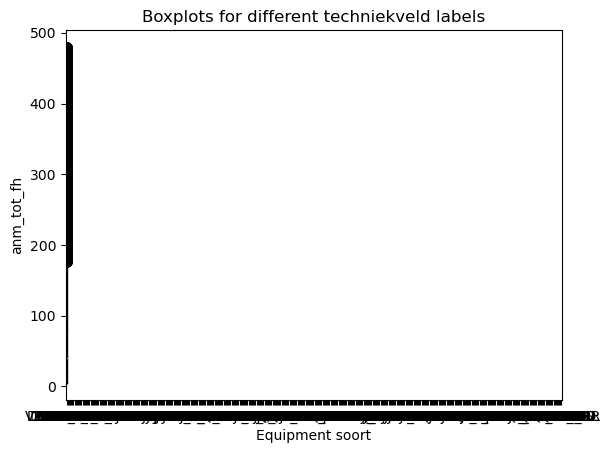

In [68]:
boxplot_data = [df[df.stm_techn_mld == value]['anm_tot_fh'] for value in df['stm_equipm_soort_mld'].unique()]

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.set_xticklabels(df['stm_equipm_soort_mld'].unique())
ax.set_xlabel('Equipment soort')
ax.set_ylabel('anm_tot_fh')
plt.title('Boxplots for different techniekveld labels')
plt.show()

In [98]:
len(dfprog), len(df)

(415434, 544583)

In [94]:
df.sample(20)

,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_meldtekst_lang,stm_sap_meldtekst,stm_geo_mld,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,...,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,aanntpl_ddt,anm_tot_fh
#stm_sap_meldnr,,,,,,,,,,,,,,,,,,,,,
80896403,0.0,,14/09/2017 16:14:56,Br-Hrt : km 5.1 Boom/Tak binnen PVR/op spoor. ...,Br-Hrt : km 5.1 Boom/Tak binnen PVR/op s,55,11563817.0,PLAATSBEP,Plaatsbepaling 055 Br-Ehv,0.0,...,45.0,14/09/2017,17:45:00,,,,,,2017-09-14 16:40:00,20.016667
80675712,0.0,,17/07/2012 07:14:00,Ehb : INFO+ PUB-HARM-CRIS omroep gestoord,Ehb : INFO+ PUB-HARM-CRIS omroep gestoor,618,11169998.0,TBHHARDW,Ehv Info+ HARM - PUB -CRIS centraal syst,51120.0,...,45.0,17/07/2012,08:18:00,,,,,,2012-07-17 07:18:00,44.000000
70286464,0.0,,03/07/2017 23:27:22,Kfhaz : Wpk 7-457 Op Intel buurTrdl Emm niet ...,Kfhaz : Wpk 7-457 Op Intel buurTrdl Emm,924,11241236.0,ICTINFRA,Post21 werkplekken Kijfhoek,0.0,...,25.0,,00:00:00,,,,,,2017-07-03 23:32:37,23.350000
80560858,0.0,,30/05/2010 01:11:00,Ut : Wpk 14-112 VKL vast,Ut : Wpk 14-112 VKL vast,531,10636480.0,TBHHARDW,TVTK 14-112 UT RVL TDL TL (PUVH0D/VT),34930.0,...,7.0,30/05/2010,01:23:00,,,,,,2010-05-30 01:13:00,6.000000
80425696,0.0,,24/09/2007 13:33:00,Rsd-Vs : Km 10.6-10.7 afrastering vernield,Rsd-Vs : Km 10.6-10.7 afrastering vernie,127,10524777.0,HEKWERK,Rsd-Vs 10.320-10.740 Raster/Hekwerk,10320.0,...,95.0,,00:00:00,,,,,,2007-09-24 14:37:00,31.000000
80494957,518361.0,AH,26/02/2009 04:36:00,Dvn-Zv: t.h.v. km 105.3 meerdere ovw gestoord...,Dvn-Zv: t.h.v. km 105.3 meerdere ovw ges,38,NaN,,,0.0,...,599.0,26/02/2009,14:35:00,"Melding is van 04:36, om 14:00 ontvangen",ZV,,ZV,DVN,2009-02-26 14:25:00,10.000000
80845677,0.0,,25/04/2016 08:52:06,2+Alm : nieuw wl-2205 Thermietlaslas gebroken...,2+Alm : nieuw wl-2205 Thermietlaslas geb,135,11478277.0,WISSEL,135 Alm wl 225A,14726.0,...,193.0,25/04/2016,12:06:00,Gestoord object: SPOOR 902. Gestoord ond,,,,,2016-04-25 10:27:05,97.916667
80824197,0.0,,25/10/2015 12:14:00,Ehv-Hm : 3kV synchronisatie frequent gestoord,Ehv-Hm : 3kV synchronisatie frequent ges,55,NaN,,,0.0,...,1537.0,28/10/2015,08:14:00,,,,,,2015-10-26 12:18:00,116.000000
80547894,0.0,,28/02/2010 02:52:00,"Ps : sp RE, hotbox offline.","Ps : sp RE, hotbox offline.",950,10957136.0,HOTBOXDET,950 km 11.414 Hotbox Pernis sp RE,11414.0,...,23.0,28/02/2010,03:16:00,,,,,,2010-02-28 03:00:00,15.000000


In [100]:
len(df[df.stm_progfh_in_duur != 99999999])

486324

In [109]:
df[['stm_geo_mld', 'stm_oorz_code']].sample(20)

,stm_geo_mld,stm_oorz_code
#stm_sap_meldnr,,
80403554,128.0,225.0
70354297,564,212.0
80873119,555,221.0
70358162,217,151.0
80758382,26,215.0
80836964,517,221.0
80401841,80.0,135.0
80738585,55,218.0
80656924,6,215.0


In [115]:
display(df['stm_geo_mld'].dtypes), type(df['stm_geo_mld'].iloc[3])

dtype('O')

(None, str)

In [151]:
df = df[df.stm_geo_mld != '']
df['stm_geo_mld'] = df['stm_geo_mld'].astype(float).astype(int)
df['stm_oorz_code'] = df['stm_oorz_code'].fillna(221).astype(int) # most 'other' categorie
df['stm_geo_mld'].unique()

array([104, 133,  23, 132, 586, 950,  34, 558, 119, 123, 135, 105, 152,
       203, 514,  63, 557, 817,  62, 112, 520, 560, 519, 309,  60, 545,
        57,  85, 122, 433, 818, 127, 564,  67, 563,  59, 851, 518, 130,
       561, 544,  70, 625, 536, 107, 534, 120, 504, 131, 553, 801, 661,
       823, 143, 551, 146, 121, 103,  72, 852, 559,  64,  71,  58, 126,
        66, 521, 565,  65, 228, 814, 503,  17, 212, 522,  91,  96, 145,
        43, 543, 532, 924, 531,  76,  28, 617, 618, 217, 206, 490, 115,
       201,  36,   9, 541, 513, 509, 208, 603,  47, 211,  15,  21, 555,
        73,  55, 805, 506, 226, 548, 117,  51, 476, 109, 587,  88, 537,
        25,  26, 663,  20, 540, 542, 124, 604, 435,  42, 527,  12, 102,
       588, 607, 533, 486, 609, 470, 803, 200,  31,  49, 528, 118,  98,
       210, 517, 525,  35,  56, 606, 605,   6,  54, 524,  27,   1, 624,
       467,   2, 508, 477, 163,  53, 620, 922,  79, 116, 940, 523, 664,
       585,  46, 900, 437, 128, 549, 927,  11,  80, 539,  94, 10

In [158]:
tEnc = TargetEncoder()
X = np.array(df['stm_oorz_code']).reshape(-1, 1)
# X = df[['stm_oorz_code', 'stm_geo_mld']]
y = df['anm_tot_fh']
tEnc.fit_transform(X,y)

array([[64.71823666],
       [57.60815432],
       [57.60815432],
       ...,
       [57.60815432],
       [76.54280299],
       [36.2011025 ]])

In [160]:
tEnc.fit(X,y)

TargetEncoder()

In [164]:
tEnc.transform(X)

array([[66.58782005],
       [57.56853506],
       [57.56853506],
       ...,
       [57.56853506],
       [76.63969169],
       [36.35381239]])

In [159]:
tEnc.encodings_[0]

array([135.        ,   7.        , 121.9023652 ,  95.33109607,
        92.31668998,  79.44467214,  77.79308487,  76.63969169,
        62.2459161 ,   7.        ,  72.69104769,  44.32638097,
        64.13006743,  36.35381239, 107.56622618,  47.1495261 ,
        47.16122112,  53.36613956,  33.84595047,  65.51288517,
        59.86708097,  64.24039232, 112.08298491,  37.73623535,
        97.11558941,  77.21622042,  62.76282841,  63.01480066,
        80.8618117 ,  62.14237376,  82.57805753,  74.93694213,
       115.01409445,  65.02096014,  91.77225503,  96.47603367,
        75.38106355,  54.74530322,  87.13437026,  95.36603642,
        86.63567235,  82.61272655, 133.99262397,  82.28449041,
        67.25409096,  76.25605112,  88.47760499,  88.07629014,
        57.56853506,  71.77431706,  70.34284072,  74.84536911,
        83.4551697 ,  78.61211684,  89.61532203,  31.5921633 ,
        70.10175464, 123.69073034,  65.89011588,  64.06793614,
        85.10692347, 100.7351213 ,  88.36611769,  97.95

In [155]:
tEnc.categories_

[array([ 33,  51, 130, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 154, 180, 181, 182,
        183, 184, 185, 186, 187, 188, 189, 201, 202, 203, 204, 205, 206,
        207, 208, 209, 210, 211, 212, 213, 214, 215, 218, 219, 220, 221,
        222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235,
        239, 240, 241, 242, 250, 294, 298, 299, 999]),
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 1

In [119]:
int(float('104.0'))

104

In [123]:
sorted(df['stm_geo_mld'].unique())

['',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '015',
 '016',
 '017',
 '018',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '046',
 '047',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '062',
 '063',
 '064',
 '067',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '078',
 '079',
 '080',
 '082',
 '083',
 '084',
 '085',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '1',
 '1.0',
 '10',
 '10.0',
 '100',
 '100.0',
 '101',
 '101.0',
 '102',
 '102.0',
 '103',
 '103.0',
 '104',
 '104.0',
 '105',
 '105.0',
 '106',
 '107',
 '107.0',
 '108',
 '108.0',
 '109',
 '109.0',
 '11',
 '11.0',
 '110',
 '110.0',
 '111',
 '111.0',
 '112',
 '112.0',
 '114',
 '114.0',
 '115',
 '115.0',
 

In [125]:
df[df.stm_geo_mld == '']

,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_meldtekst_lang,stm_sap_meldtekst,stm_geo_mld,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,...,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,aanntpl_ddt,anm_tot_fh
#stm_sap_meldnr,,,,,,,,,,,,,,,,,,,,,
80403581,0.0,,15/04/2007 08:28:00,Dmp:Gickkast regelmatig alarm melding proces ...,Dmp:Gickkast regelmatig alarm melding pr,,10768012.0,CABOP,"Dmp OS GIK 2M/2S Lijn 4 Op 5, 6",13250.0,...,1807.0,16/04/2007,14:40:00,,,,,,2007-04-16 14:00:00,40.0
80404950,0.0,,24/04/2007 13:18:00,Os Mss:telegyr melding hardware controle com...,Os Mss:telegyr melding hardware controle,,10768000.0,CABOP,Mss OS GIK 1M Lijn 2 Op 8,12400.0,...,101.0,24/04/2007,15:02:00,,,,,,2007-04-24 14:35:00,27.0
80405057,0.0,,25/04/2007 06:19:00,Os Mss:Opnieuw telegyr melding hardware contr...,Os Mss:Opnieuw telegyr melding hardware,,10768000.0,CABOP,Mss OS GIK 1M Lijn 2 Op 8,12400.0,...,489.0,25/04/2007,14:37:00,,,,,,2007-04-25 09:00:00,330.0
80405273,0.0,,26/04/2007 08:20:00,Os Mss:Telegyr Hardware:kommando uitgifte ala...,Os Mss:Telegyr Hardware:kommando uitgift,,10768000.0,CABOP,Mss OS GIK 1M Lijn 2 Op 8,12400.0,...,370.0,26/04/2007,16:00:00,,,,,,2007-04-26 09:53:00,282.0
80435243,0.0,,05/12/2007 08:56:00,YPB systeem-alarm TG805 onderpost. gaarne d...,YPB systeem-alarm TG805 onderpost. gaa,,10768013.0,CABOP,Ypb OPH GIK 2M Lijn 4 Op 7,13250.0,...,121.0,05/12/2007,11:00:00,,,,,,2007-12-05 09:45:00,75.0


In [145]:
sorted(df['stm_oorz_code'].unique())

[132.0,
 133.0,
 135.0,
 140.0,
 142.0,
 143.0,
 145.0,
 146.0,
 147.0,
 149.0,
 150.0,
 151.0,
 154.0,
 184.0,
 201.0,
 203.0,
 207.0,
 212.0,
 213.0,
 214.0,
 215.0,
 218.0,
 219.0,
 221.0,
 222.0,
 224.0,
 225.0,
 226.0,
 228.0,
 230.0,
 235.0,
 240.0,
 241.0,
 250.0,
 294.0,
 298.0,
 299.0,
 nan,
 33.0,
 51.0,
 130.0,
 131.0,
 134.0,
 136.0,
 139.0,
 141.0,
 144.0,
 148.0,
 180.0,
 181.0,
 182.0,
 183.0,
 185.0,
 186.0,
 187.0,
 188.0,
 189.0,
 202.0,
 204.0,
 205.0,
 206.0,
 208.0,
 209.0,
 210.0,
 211.0,
 220.0,
 223.0,
 227.0,
 229.0,
 231.0,
 233.0,
 234.0,
 239.0,
 242.0,
 999.0]

In [138]:
df.stm_oorz_code.isna().sum(), len(df)

(8039, 544578)

In [139]:
df.stm_oorz_code.fillna(221)

#stm_sap_meldnr
50112759    299.0
50129194    218.0
50129194    218.0
50142091    299.0
50142091    299.0
            ...  
99003505    215.0
99003506    218.0
99003506    218.0
99999999    135.0
99999999    143.0
Name: stm_oorz_code, Length: 544578, dtype: float64